# Survival Analysis of Endometrial Cancer: Tumor Pathological Stage

Through modern statistical methods, we can determine survival risk based on a variety of factors.  In this tutorial, we will walk through a small example of something you could do with our data to understand what factors relate with survival in various different types of cancer.  In this use case, we will be looking at Endometrial Cancer

## Step 1: Import Data and Dependencies

In [129]:
import pandas as pd
import cptac
import numpy as np
import sksurv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [130]:
en = cptac.Endometrial()
clinical = en.get_clinical()
proteomics = en.get_proteomics()
follow_up = pd.read_excel('../Follow_Up_Data/UCEC_followup_9_12.xlsx')

## Step 2: Data Preparation
We will be focusing on the discovery cohort of tumors, for which we have follow-up data. We will perform some data cleaning, and then merge the tables together for analysis. While you could study a wide variety of factors related to survival, such as country of origin or number of full pregnancies, we will be focusing on tumor stage and grade.

In [131]:
#Get just the discovery cohort
cohort_filter = follow_up['Cohort'] == "Disc"
discovery_cohort = follow_up[cohort_filter].copy()
other_cohort = follow_up[~cohort_filter]

In [132]:
#Replace things that mess up the analysis       
to_replace = ['Not Reported/ Unknown', 'Reported/ Unknown',
              'Not Applicable', 'na', 'unknown', 'Not Performed',
              'Unknown tumor status', 'Unknown',
              'Unknown Tumor Status', 'Not specified']

for col in discovery_cohort.columns:
    discovery_cohort[col] = discovery_cohort[col].replace(to_replace, 
                                                          np.nan)

In [133]:
#Rename column to merge on, and then merge follow-up with clinical data
discovery_cohort = discovery_cohort.rename({'Case ID': 'Patient_ID'}, axis='columns')

patient_data = pd.merge(clinical, discovery_cohort, on = 'Patient_ID')

In [134]:
#Determine columns to focus on, and create a subset to work with
columns_to_focus_on = ['Patient_ID', 'Vital Status', 
                       'Histologic_Grade_FIGO', 
                       'Path Diag to Last Contact(Day)', 
                       'Path Diag to Death(days)', 
                       'Histologic_type',
                       'tumor_Stage-Pathological',
                       'Path Diag to new Tumor (days)', 
                       'New Tumor After Initial TRT', 
                       'Success of Initial Treatment', 
                       'Success of Treatment@ Followup']

focus_group = patient_data[columns_to_focus_on].copy().drop_duplicates()

In [135]:
#Negative outcomes are defined as:
#Death, new tumor event, or persistent disease 
#(going to try this with persistent disease. 
#not sure if I can find a timeframe with it)

#Timeframe will be defined as: (DONE)
#if new_tumor: Path Diag to new Tumor (days)
#elif death: Path Diag to Death(days)
#else: Path Diag to Last Contact(Day)

In [136]:
new_tumor = focus_group["New Tumor After Initial TRT"] == "Yes"
deceased = focus_group["Vital Status"] == "Deceased"
persistent1 = focus_group["Success of Initial Treatment"] == "Persistent Disease"
persistent2 = focus_group["Success of Treatment@ Followup"] == "Persistent Disease"

In [137]:
new_tumor_patients = focus_group.Patient_ID[new_tumor]
deceased_patients = focus_group.Patient_ID[deceased]
persist_init = focus_group.Patient_ID[persistent1]
persist_fol_up = focus_group.Patient_ID[persistent2]

In [138]:
neg_outcomes_list = [new_tumor_patients, deceased_patients, 
                     persist_init, persist_fol_up]

In [139]:
neg_outcomes = new_tumor_patients.append(deceased_patients).drop_duplicates()
neg_outcomes = neg_outcomes.append(persist_init).drop_duplicates()
neg_outcomes = neg_outcomes.append(persist_fol_up).drop_duplicates()

In [140]:
focus_group['Negative_Outcome'] = neg_outcomes

In [141]:
focus_group['Negative_Outcome'] = focus_group['Negative_Outcome'].replace(neg_outcomes.values, True)
focus_group['Negative_Outcome'] = focus_group['Negative_Outcome'].replace(np.nan, False)

## Step 2b: Prepare data for Kaplan Meier Plotting and Survival Analysis

In [142]:
##Not sure about the -1562, but I'll filter it out for now
focus_group = focus_group[focus_group['Path Diag to new Tumor (days)'] != -1562.0]

In [143]:
focus_group['Timeframe'] = np.nan

In [144]:
temp_neg_outcomes = focus_group[focus_group["Negative_Outcome"] == True].copy()

In [145]:
new_tumor_times = temp_neg_outcomes['Path Diag to new Tumor (days)'][temp_neg_outcomes["New Tumor After Initial TRT"] == "Yes"]

In [146]:
death_times = temp_neg_outcomes['Path Diag to Death(days)'][temp_neg_outcomes["Vital Status"] == "Deceased"]

In [147]:
for i in death_times.index:
    if i in new_tumor_times.index:
        death_times = death_times.drop([i])

In [148]:
time_frames = new_tumor_times.append(death_times).drop_duplicates()

In [149]:
temp_neg_outcomes['Timeframe'] = temp_neg_outcomes['Timeframe'].replace(np.nan, time_frames)

In [150]:
focus_group['Timeframe'] = focus_group['Timeframe'].replace(np.nan, time_frames)
focus_group['Timeframe'] = focus_group['Timeframe'].replace(np.nan, focus_group['Path Diag to Last Contact(Day)'])

In [151]:
focus_group = focus_group[["Histologic_Grade_FIGO", "tumor_Stage-Pathological", 
                           "Negative_Outcome", "Timeframe"]].dropna().copy()

For Kaplan Meier plots, your data needs to be in a format similar to that shown below.  Particularly, it needs a boolean column for the 'event' you are interested in (in this case, "Negative_Outcome"), where True denotes the event you are tracking, and False denotes an individual that never had the event of interest occur (in this case, their vital status is 'living').  It also needs a column with a numeric time frame, which we have as 'Timeframe'.  The other columns contain categorical data that we are testing to find meaningful connections with positive or negative event outcomes.

In [153]:
time = focus_group['Timeframe'].copy()
status = focus_group['Negative_Outcome'].copy()

Kaplan Meier plots show us the probability of some event occuring over a given length of time, based on some attribute.  Oftentimes, they are used to plot the probability of death for different attributes, however they could also be used in a variety of other contexts.  Below are a few examples of Kaplan Meier Plots in regards to Histologic Grade, and Tumor Stage of patients with Endometrial Cancer:

Here, we show a general Kaplan Meier Plot of survival overall for our cohort

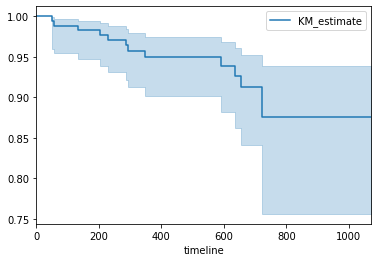

In [154]:
kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

In [155]:
#Prepare columns of interest for survival regression fitting and analysisHowever, with the CoxPHFitter, we can see more in-depth survival plots based on multiple variables, as shown below.
figo_map = {"FIGO grade 1": 1, "FIGO grade 2": 2, "FIGO grade 3" : 3}
focus_group['Histologic_Grade_FIGO'] = focus_group['Histologic_Grade_FIGO'].map(figo_map)

tumor_map = {"Stage I" : 1, "Stage II" : 2, "Stage III" : 3, "Stage IV" : 4}
focus_group['tumor_Stage-Pathological'] = focus_group['tumor_Stage-Pathological'].map(tumor_map)

With the CoxPHFitter, however, we can see more in-depth survival plots based on multiple variables, as shown below.

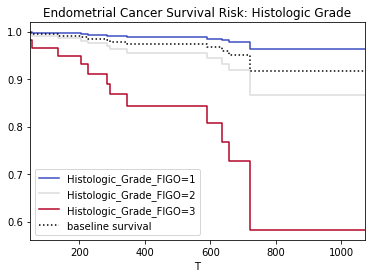

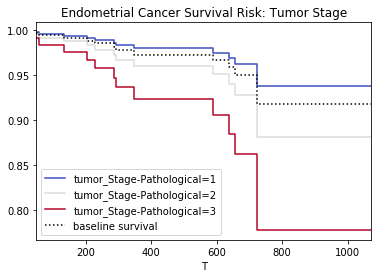

In [157]:
cph = CoxPHFitter()
cph.fit(focus_group, duration_col = "Timeframe", event_col = "Negative_Outcome")
cph.plot_covariate_groups('Histologic_Grade_FIGO', [1,2,3], cmap='coolwarm', 
                          title= "Endometrial Cancer Survival Risk: Histologic Grade")
cph.plot_covariate_groups('tumor_Stage-Pathological', [1,2,3], cmap='coolwarm', 
                          title= "Endometrial Cancer Survival Risk: Tumor Stage")

These plots appear to have very similar functions across the variables, however, Histologic_Grade_FIGO=3 tends to have more negative outcomes than tumor_Stage-Pathological=3.  As shown below with our Survival Regression analysis, Histologic Grade has a lower p-value than Tumor Stage, which is to be expected, since more negative outcomes occurred for patients with Histologic Grade 3 tumors.

In [158]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 172 total observations, 160 right-censored observations>
      duration col = 'Timeframe'
         event col = 'Negative_Outcome'
number of observations = 172.0
number of events observed = 12.0
partial log-likelihood = -48.063
  time fit was run = 2019-12-12 23:16:26 UTC
             model = untransformed variables


---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
Histologic_Grade_FIGO    1.324     3.760     0.423           0.496           2.153               1.642               8.611
tumor_Stage-Pathological 0.685     1.984     0.286           0.124           1.246               1.132               3.476

                             z     p  -log2(p)
Histologic_Grade_FIGO    3.132 0.002     9.172
tumor_Stage-Pathological 2.394 0.017     5.908
---
Concordance = 0.789
Log-likelihood ratio test = 17.053 on 2 df, -log2(p)=12.301


We then can perform a Cox Proportional Hazard test to determine how much more or less risk a patient would have for the event of interest to occur based on the variables that we are looking at, and to determine if these variables explain a statistically significant amount of the negative outcomes (moreso than would be expected by random chance).

In [159]:
results = proportional_hazard_test(cph, focus_group, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
                          test_statistic     p  -log2(p)
Histologic_Grade_FIGO              0.229 0.632     0.661
tumor_Stage-Pathological           0.477 0.490     1.030


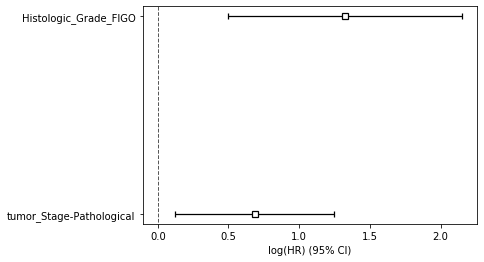

In [160]:
cph.plot()